# Morphology predictions vs actual DSI comparisons pipeline
- get predictions of morphology - calculated preferred dir
- regress with functional DSI 
- relate with cell type (eg L2/3 vs L4)

In [1]:
# connectomics imports
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/em-connectomics"
    
# OR if you'd like to override the auto options
# data_root = "./proofread_skeletons/"

In [2]:
# this is the EM specific package for querying the EM data
from caveclient import CAVEclient


In [3]:
# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

/Users/anamika.agrawal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# if this errors, go to the CAVEsetup notebook
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)

In [5]:
#coreg_df = pd.read_feather('coreg_good_scans_func_resp_dsi.feather')
coreg_df = pd.read_feather('coreg_all_good_scans_dsi_osi.feather')
good_unit_ids = [4862,2075,5543,3210,3287,3551,6076,8228,5185,2724,6529]
DSIdf = coreg_df[coreg_df.unit_id.isin(good_unit_ids)]

In [6]:
highDSIdf = coreg_df[(coreg_df.DSI >= 0.5) & (coreg_df.Act_Pref_Dir >= 20)]

In [7]:
highDSIdf = highDSIdf.sort_values(by=['DSI'],ascending=False)

In [8]:
highDSIdf.columns

Index(['unit_id', 'pref_dir', '0.0', '22.5', '45.0', '67.5', '90.0', '112.5',
       '135.0', '157.5', '180.0', '202.5', '225.0', '247.5', '270.0', '292.5',
       '315.0', '337.5', 'null_dir', 'DSI', 'Act_Pref_Dir', 'OSI',
       'Act_Pref_Or', 'pref_or', 'null_or', 'session', 'scan_idx', 'nframes',
       'nfields', 'fps', 'id', 'valid', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position'],
      dtype='object')

In [9]:
highDSIdf.iloc[0][2]

7.307983875274658

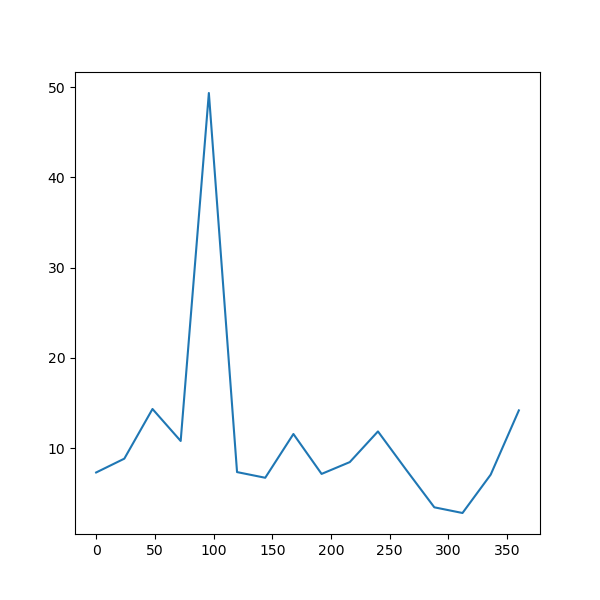

In [10]:
# check activity plot for a sample cell
fig, ax = plt.subplots(figsize=(6,6))
activityLvls= highDSIdf.iloc[0][2:18]
angles = np.linspace(0,360,16)
ax.plot(angles, activityLvls)

In [11]:
lowDSIdf = coreg_df[(coreg_df.DSI <= 0.07) & (coreg_df.Act_Pref_Dir >= 20) & (np.vstack(coreg_df.pt_position.values)[:,0]/1000 < 1000)]

In [12]:
lowDSIdf = lowDSIdf.sort_values(by=['DSI'])

864691135577854148
[-1.09044951]
864691136925654346
[1.26521542]
864691135815504719
[1.20643803]
864691136378793429
864691135945447460
[-1.12708619]
864691135122469671
[-2.89223498]
864691136911626993
[-1.29951156]
864691135748803881
[0.58709345]
864691136378779605
[2.8504628]
864691135012894358
[-0.25504989]
864691135615762537
[-1.89612198]
864691135855861806
[-2.80245691]
864691135526055515
[-0.99156411]
864691135968899173
[-2.47051011]
864691135445704338
[2.85480879]
864691135348288727
[-2.94552728]
864691136749441902
[1.47499683]
864691135675330756
864691135488213050
[2.23879141]
864691135293059340
[0.4756046]
864691135780953680
[-2.42365455]
864691135440777032
[-0.99088604]
864691135858681704
[-2.92367493]
864691135724497579
[2.84818931]
864691135478395078
[1.31479263]
864691135385241941
[-0.4502522]
864691135341159877
[1.44014608]
864691135462702237
[2.50505836]
864691135700379259
[-1.02053963]
864691136237523516
[-2.02663751]
864691135393999861
[2.88535607]
864691135638959675
[-

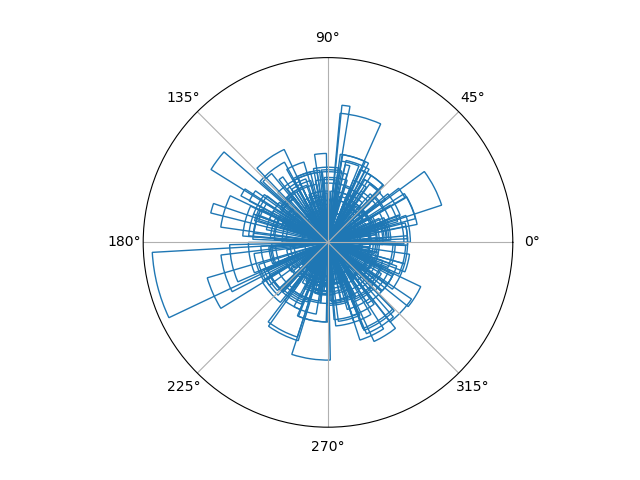

In [13]:
# iterate over N = 20-50 neurons to calculate major Axis orientations
# for high DSI/OSI and low DSI/OSI
# For Basal and Apical:  synaptic density,cable length qty (for now - use skeleton vertices),avg syn size
from meshparty import meshwork
from angularUtils import *
from meshparty.skeleton import resample
from scipy import signal

N = 20
Ncells = N
theta_highDSI = np.zeros((N,1))
theta_highDSI[:] = np.nan
nuc_id_list_highDSI = np.zeros((N,1))
mesh_files_highDSI = []
dsi_theta_highDSI = np.zeros((N,1))
dsi_theta_highDSI[:] = np.nan
correlation_highDSI = np.zeros((N,1))
correlation_highDSI[:] = np.nan
lag_highDSI = np.zeros((N,1))
lag_highDSI[:] = np.nan
angularHet_highDSI = np.zeros((N,1))
nuc_type_highDSI = []
allSig1activity_highDSI = []
allSig2morph_highDSI = []
fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(Ncells):
    neuron_id = highDSIdf.iloc[i].pt_root_id
    print(neuron_id)
    
    neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
    
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue
        
    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    nuc_id_list_highDSI[i] = nuc_id
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    if not (os.path.exists(os.path.join(data_root,mesh_filename))):
        continue
        
    dsi_theta_highDSI[i] = highDSIdf.iloc[i].pref_dir * (np.pi/180)
    nuc_type_highDSI.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    #mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    mesh_files_highDSI.append(mesh_filename)
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    
    # get basal dendrite mesh
    #basal_dendrite_mesh = nrn.anno.basal_mesh_label.mesh_index
    #basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    
    # get apical dendrite mesh
    #apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    #apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    #apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df
    syndf_axon = nrn.anno.pre_syn.df

    #syn_pos_apical = np.vstack(syndf_apical['ctr_pt_position'].values)
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    
    #
    syn_pos_axon = np.vstack(syndf_axon['ctr_pt_position'].values)
    syn_pos_axon_norm = np.column_stack((syn_pos_axon[:,0]*4, syn_pos_axon[:,1]*4, syn_pos_axon[:,2]*40))
    skeleton_vertices = syn_pos_axon_norm
    
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial[:,1]
    x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    #bins = np.linspace(-np.pi, np.pi, num=17)
    n, bins, patches = circular_hist(ax, x, weights=np.ones_like(x), bins=16, density=True, offset=0, gaps=True)
    #n, bins = np.histogram(x, bins=bins)
    theta_highDSI[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0]) + np.pi
    print(theta_highDSI[i])
    angularHet_highDSI[i] = np.max(n)/np.mean(n)
    
    # correlations and lags
    activityLvls= highDSIdf.iloc[i][2:18]
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    allSig1activity_highDSI.append(sig1activity)
    allSig2morph_highDSI.append(sig2morph)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag_highDSI[i] = lags[np.argmax(abs(correlation))]
    correlation_highDSI[i] = np.max(abs(correlation))
    

theta_lowDSI = np.zeros((N,1))
theta_lowDSI[:] = np.nan
nuc_id_list_lowDSI = np.zeros((N,1))
mesh_files_lowDSI = []
dsi_theta_lowDSI = np.zeros((N,1))
dsi_theta_lowDSI[:] = np.nan
angularHet_lowDSI = np.zeros((N,1))
correlation_lowDSI = np.zeros((N,1))
correlation_lowDSI[:] = np.nan
lag_lowDSI = np.zeros((N,1))
lag_lowDSI[:] = np.nan
nuc_type_lowDSI = []

allSig1activity_lowDSI = []
allSig2morph_lowDSI = []

for i in range(Ncells):
    neuron_id = lowDSIdf.iloc[i].pt_root_id
    print(neuron_id)
    neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')
    
    if (len(neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values) == 0):
        continue

    nuc_id = neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
    nuc_id_list_lowDSI[i] = nuc_id
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    if not (os.path.exists(os.path.join(data_root,mesh_filename))):
        continue
            
    dsi_theta_lowDSI[i] = lowDSIdf.iloc[i].pref_dir * (np.pi/180)
    nuc_type_lowDSI.append(neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0])
    mesh_filename = f"{neuron_id}_{nuc_id}.h5"
    
    mesh_files_lowDSI.append(mesh_filename)
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))
    
    # get basal dendrite mesh
    #basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
    #basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    
    # get apical dendrite mesh
    #apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
    #apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index
    #apical_dendrite_mask = nrn.anno.apical_mesh_labels.skel_index.to_mesh_mask
    
    
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syndf_apical = nrn.anno.post_syn.filter_query(apical_dendrite_mask).df
    syndf_axon = nrn.anno.pre_syn.df


    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    
    #syn_pos_apical = np.vstack(syndf_apical['ctr_pt_position'].values)
    #syn_pos_apical_norm = np.column_stack((syn_pos_apical[:,0]*4, syn_pos_apical[:,1]*4, syn_pos_apical[:,2]*40))
    #skeleton_vertices = syn_pos_apical_norm
    
    syn_pos_axon = np.vstack(syndf_axon['ctr_pt_position'].values)
    syn_pos_axon_norm = np.column_stack((syn_pos_axon[:,0]*4, syn_pos_axon[:,1]*4, syn_pos_axon[:,2]*40))
    skeleton_vertices = syn_pos_axon_norm
    
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    #somapos = [nrn_somapos[0], nrn_somapos[1], nrn_somapos[2]]
    
    
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.2*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial[:,1]
    x = skel_pos_radial_farther[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    n, bins, patches = circular_hist(ax, x, weights=np.ones_like(x), bins=16, density=True, offset=0, gaps=True)   
    theta_lowDSI[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    print(theta_lowDSI[i])
    #theta[i] = np.arctan2(majorAxis[1],majorAxis[0])
    #theta[i] = (bin_edges[hist.argmax()] + bin_edges[hist.argmax() + 1])/2
    angularHet_lowDSI[i] = np.max(n)/np.mean(n)
    
    # correlations and lags 
    activityLvls= lowDSIdf.iloc[i][2:18]
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    allSig1activity_lowDSI.append(sig1activity)
    allSig2morph_lowDSI.append(sig2morph)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag_lowDSI[i] = lags[np.argmax(abs(correlation))]
    correlation_lowDSI[i] = np.max(abs(correlation))

# from mean lags, get the average correlations for all time series


    

    

In [14]:
np.abs(angularHet_highDSI[~np.isnan(angularHet_highDSI)]).mean()

4.113435945014328

In [15]:
np.abs(angularHet_lowDSI[~np.isnan(angularHet_lowDSI)]).mean()

5.444789420973829

In [16]:
# get the best fit theta lag for high DSI and low DSI
# need to change the code below from Forrest's code
#vdiff = exp(1i*graddir_hor) .* exp(-1i*graddir_vert); %Should be vert-hor, but the gradient in Matlab for y is opposite.
#VFS = sin(angle(vdiff)); %Visual field sign map

[0.3881284]
10928736348.363094 -5
[2.74514431]
7744368851.55732 -4
[1.87671102]
5180668704.933311 -1
[1.95427999]
8757061175.44047 0
[-0.78537459]
10304429619.402952 -1
[-1.57163999]
7088429940.367841 -8
[2.73478596]
31129003442.982155 -6
[0.78502634]
10245529206.710218 -10
[-0.39320196]
3708383797.040575 -5
[0.53335386]
12642238585.68343 1
[2.74536459]
6234786155.834868 -1
[0.00083907]
10534544607.852583 -1
[0.78041678]
4766615005.9622755 -7
[-1.5709638]
9169470145.03863 10
[-3.14159265]
14279809916.529129 11


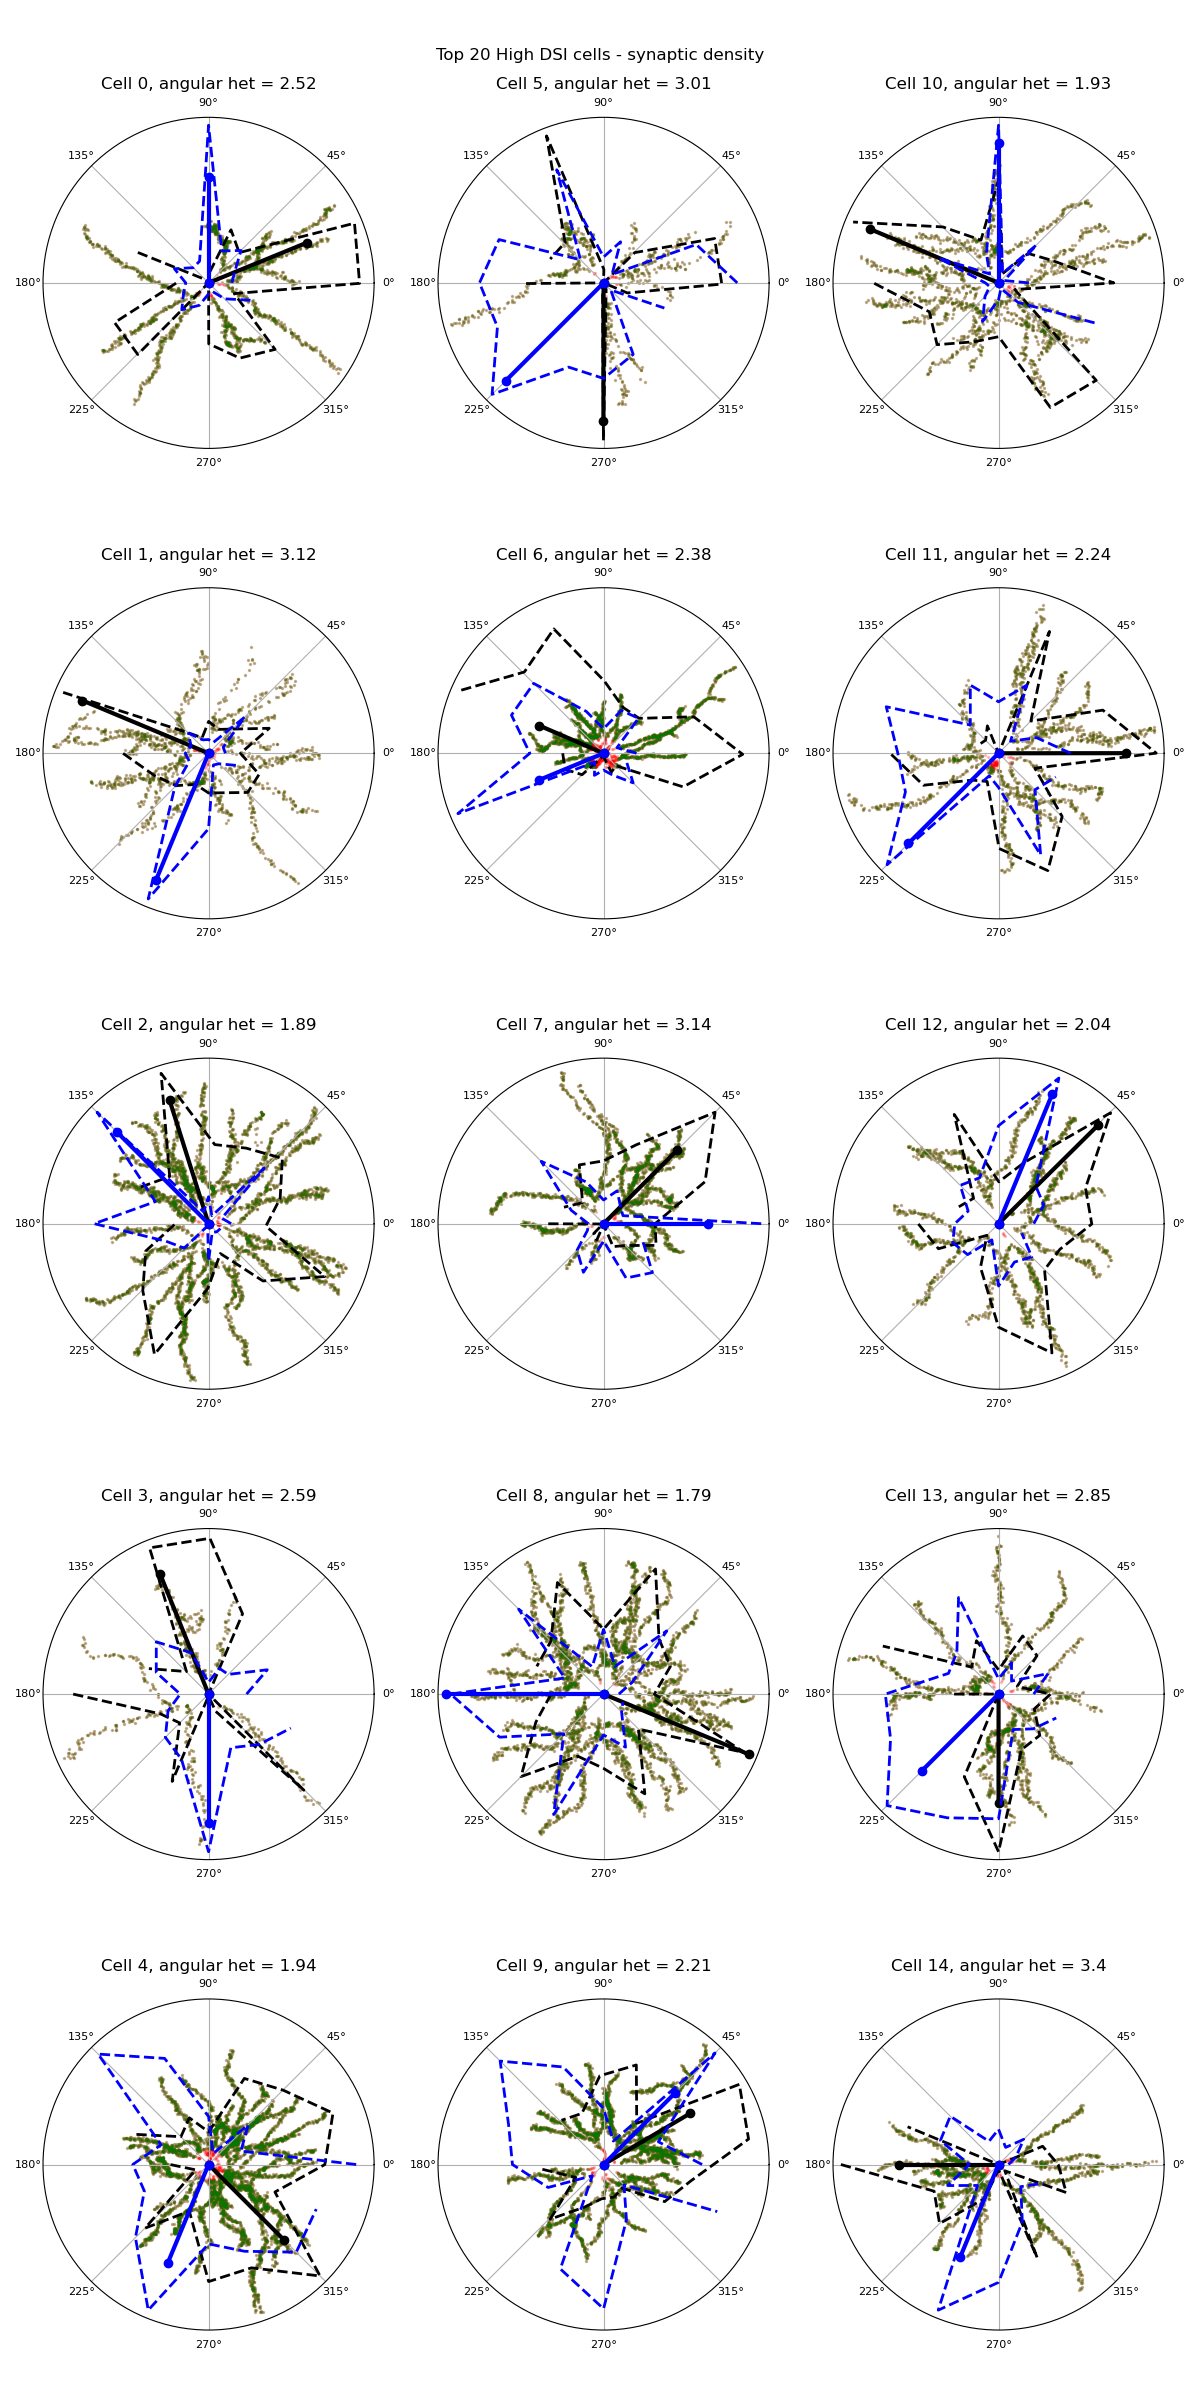

In [33]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
# visualize synaptic density 
from scipy import signal
Ncells = 15
fig, axs = plt.subplots(nrows=5, ncols=3, subplot_kw={'projection': 'polar'},figsize=(12,24))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Top 15 High DSI cells - synaptic density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_highDSI[i]))
    dsi_theta = highDSIdf.iloc[i].pref_dir * (np.pi/180)
    activityLvls= highDSIdf.iloc[i][2:18]
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    skeleton_vertices = syn_pos_basal_norm
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.1*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial_farther[:,1]
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    # left or right side
    j = int(i/5)
    k = i%5
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[k,j], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    #theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    theta[i] = bins[n.argmax()]
    print(theta[i])
    angularHet = np.max(n)/np.mean(n)
    
    #print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[k,j].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=2,color='r',alpha=0.2)
    axs[k,j].scatter(skel_pos_radial_farther[:,1], skel_pos_radial_farther[:,0],s=2,color='g',alpha=0.2)
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[k,j].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[k,j].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[k,j].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # overlay activity curve in diff directions
    activityLvls= highDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[k,j].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    axs[k,j].plot([0,dsi_theta],[0,1e5],linewidth = 3, color='b') 
    axs[k,j].plot([0,dsi_theta],[0,1e5],'bo')
    axs[k,j].set_yticklabels([])
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag = lags[np.argmax(abs(correlation))]
    print(np.max(abs(correlation)), lag)
    axs[k,j].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[k,j].title.set_text('Cell ' + str(i)+ ', angular het = '+str(np.round(angularHet,2)))
    #axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
plt.tight_layout()

[1.95592899]
9507910019.189589 -1
[-1.96362133]
11559481100.33537 8
[-2.74837046]
8078269566.523218 1
[1.18003407]
8627054324.059317 0
[-2.35174152]
10101364278.007729 8
[0.39571452]
28937040289.906666 -6
[1.1770205]
3849945383.331445 1
[2.29856762]
13978853276.587769 -4
[1.95912563]
22494086403.14932 0
[2.3558512]
5268433599.585539 4
[2.35607177]
10479572108.083801 -2
[-0.00032895]
12473475381.772507 -3
[0.78389341]
28774754413.056694 1
[-1.1734713]
8511344192.711681 3
[1.96290724]
11027518688.967394 1


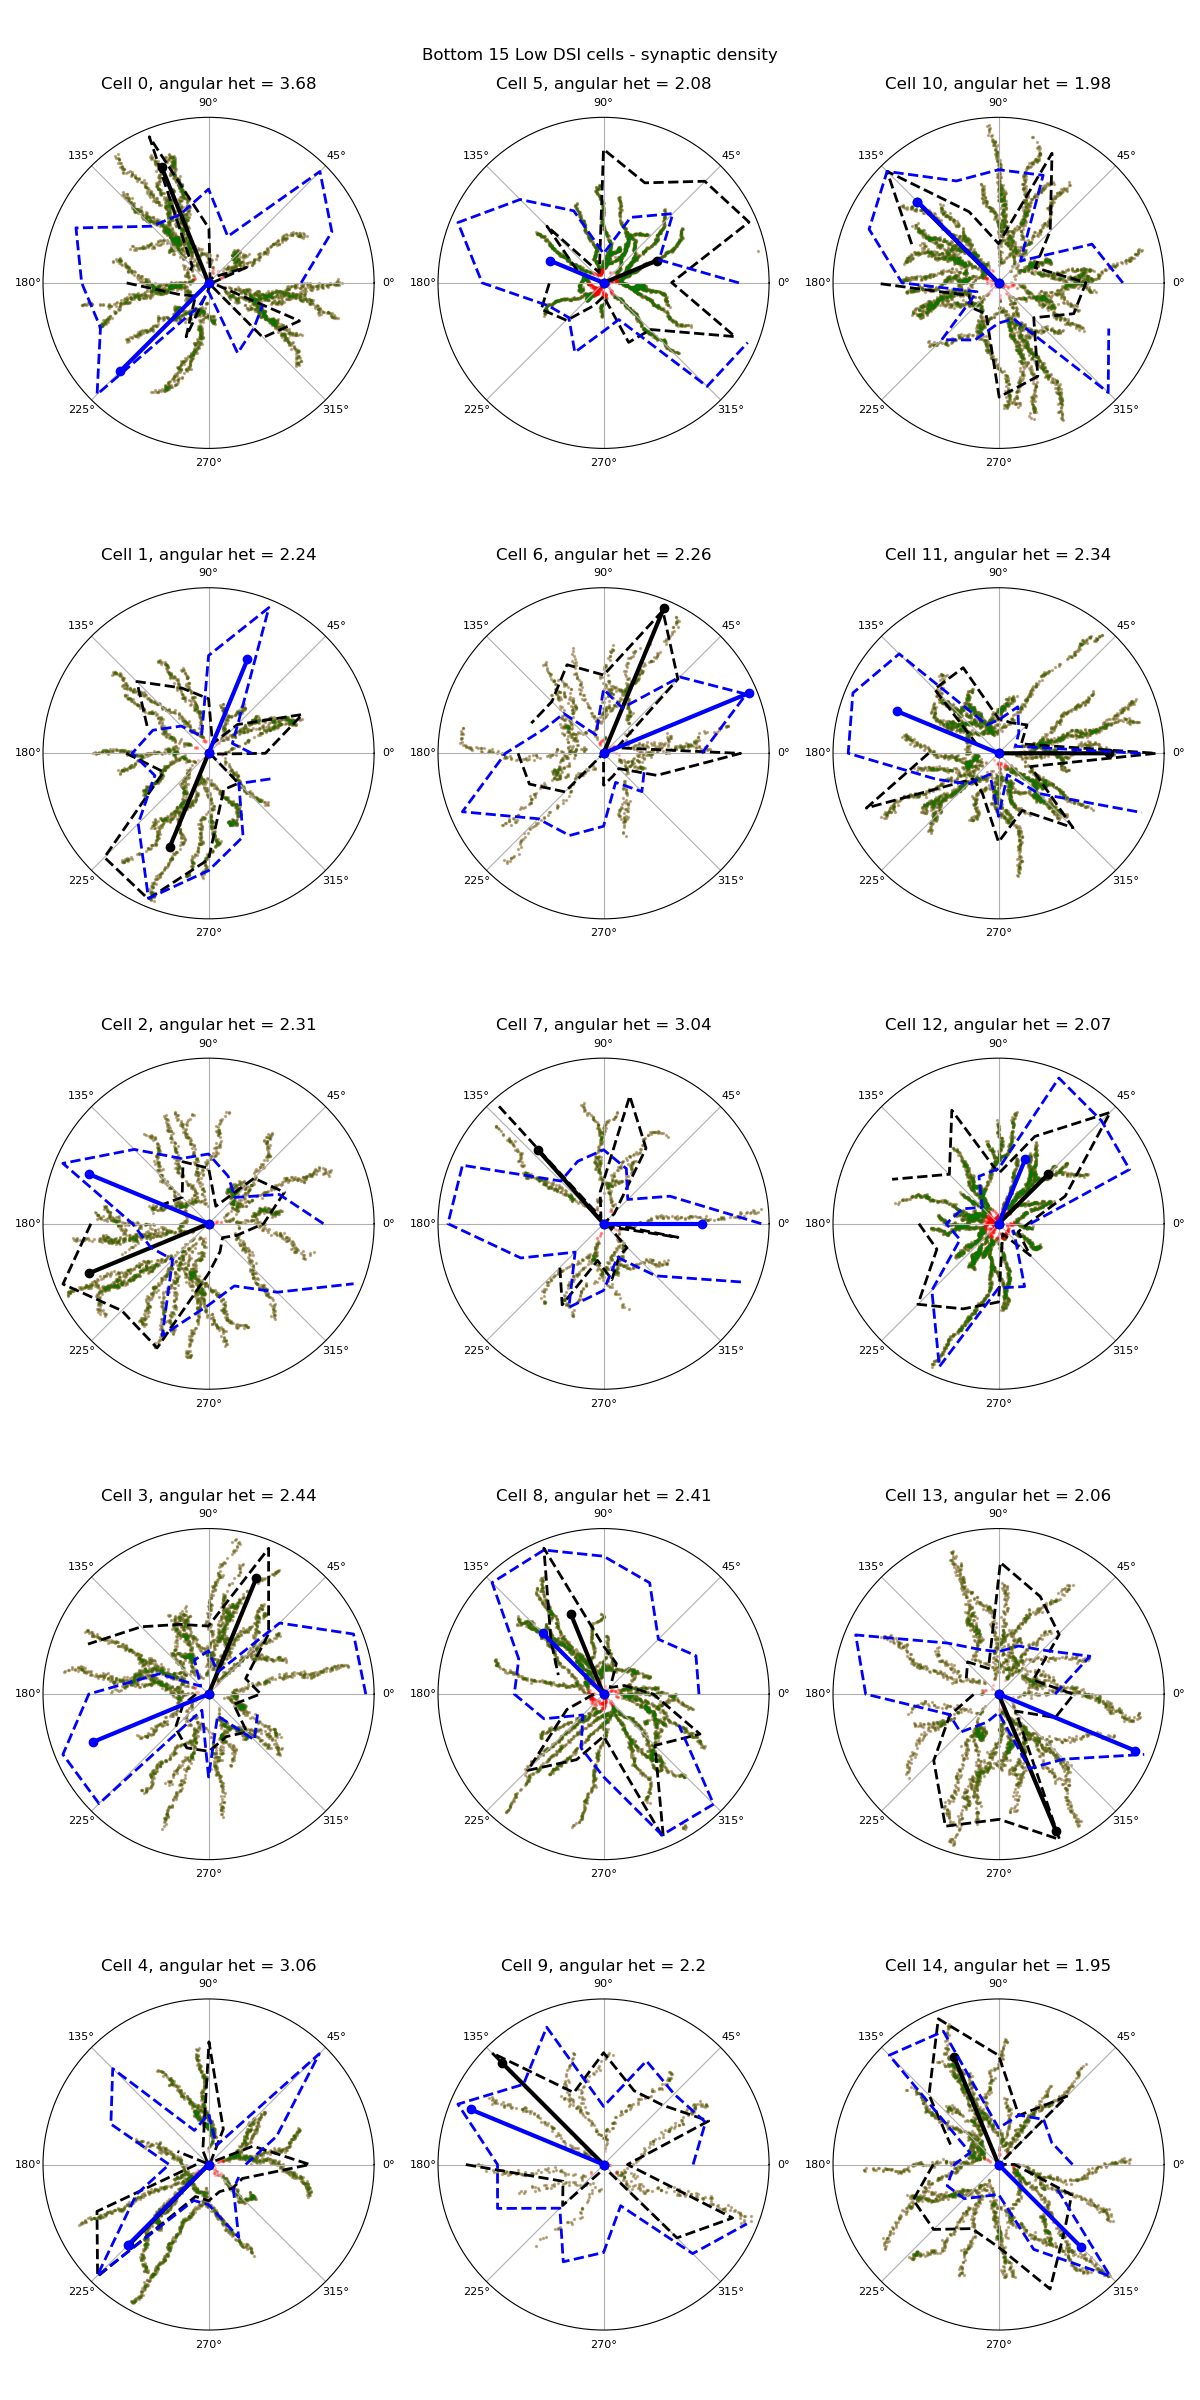

In [34]:
# visualize subplots of bottom 20 dsi cells with arrow pointing to morph dir
# visualize synaptic density 
Ncells = 15
fig, axs = plt.subplots(nrows=5, ncols=3, subplot_kw={'projection': 'polar'},figsize=(12,24))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Bottom 15 Low DSI cells - synaptic density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_lowDSI[i]))
    dsi_theta = lowDSIdf.iloc[i].pref_dir * (np.pi/180)
    activityLvls= lowDSIdf.iloc[i][2:18]
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    skeleton_vertices = syn_pos_basal_norm
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.1*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial_farther[:,1]
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    # left or right side
    j = int(i/5)
    k = i%5
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[k,j], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    #theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    theta[i] = bins[n.argmax()]
    print(theta[i])
    angularHet = np.max(n)/np.mean(n)
    
    #print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[k,j].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=2,color='r',alpha=0.2)
    axs[k,j].scatter(skel_pos_radial_farther[:,1], skel_pos_radial_farther[:,0],s=2,color='g',alpha=0.2)
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[k,j].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[k,j].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[k,j].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # overlay activity curve in diff directions
    activityLvls= lowDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[k,j].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag = lags[np.argmax(abs(correlation))]
    print(np.max(abs(correlation)), lag)
    axs[k,j].plot([0,dsi_theta],[0,1e5],linewidth = 3, color='b') 
    axs[k,j].plot([0,dsi_theta],[0,1e5],'bo')
    axs[k,j].set_yticklabels([])
    axs[k,j].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[k,j].title.set_text('Cell ' + str(i)+ ', angular het = '+str(np.round(angularHet,2)))
    #axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)

plt.tight_layout()



[0.3881284]
10928736348.363094 -5
[2.74514431]
7744368851.55732 -4
[1.87671102]
5180668704.933311 -1


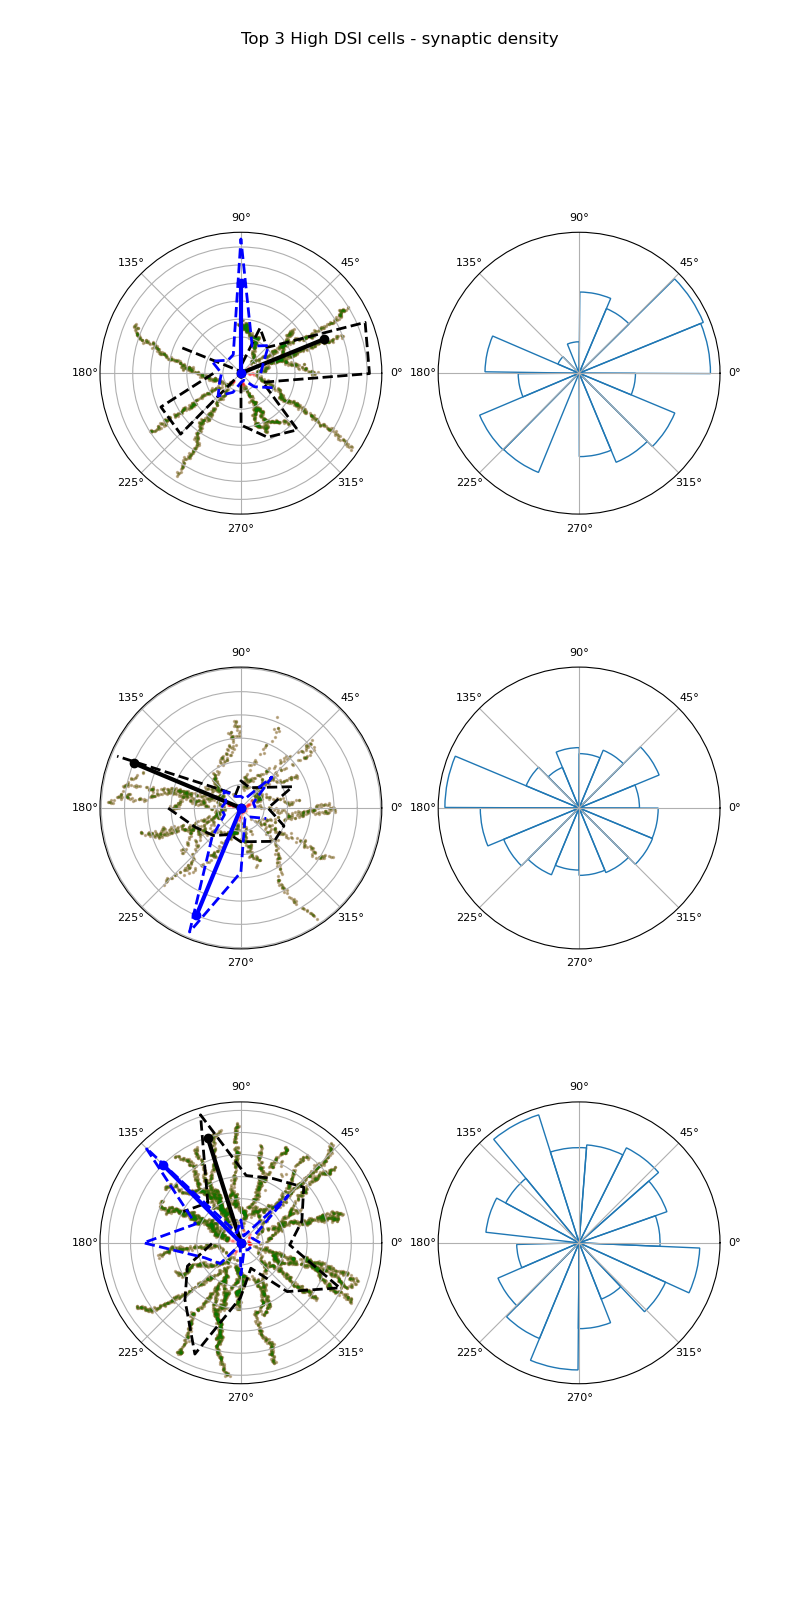

In [46]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
# visualize synaptic density 
from scipy import signal
Ncells = 3
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Top 3 High DSI cells - synaptic density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_highDSI[i]))
    dsi_theta = highDSIdf.iloc[i].pref_dir * (np.pi/180)
    activityLvls= highDSIdf.iloc[i][2:18]
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    skeleton_vertices = syn_pos_basal_norm
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.1*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial_farther[:,1]
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    #theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    theta[i] = bins[n.argmax()]
    print(theta[i])
    #print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=2,color='r',alpha=0.2)
    axs[i,0].scatter(skel_pos_radial_farther[:,1], skel_pos_radial_farther[:,0],s=2,color='g',alpha=0.2)
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[i,0].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[i,0].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[i,0].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # overlay activity curve in diff directions
    activityLvls= highDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[i,0].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    axs[i,0].plot([0,dsi_theta],[0,1e5],linewidth = 3, color='b') 
    axs[i,0].plot([0,dsi_theta],[0,1e5],'bo')
    axs[i,0].set_yticklabels([])
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag = lags[np.argmax(abs(correlation))]
    print(np.max(abs(correlation)), lag)
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    

[1.95592899]
9507910019.189589 -1
[-1.96362133]
11559481100.33537 8
[-2.74837046]
8078269566.523218 1


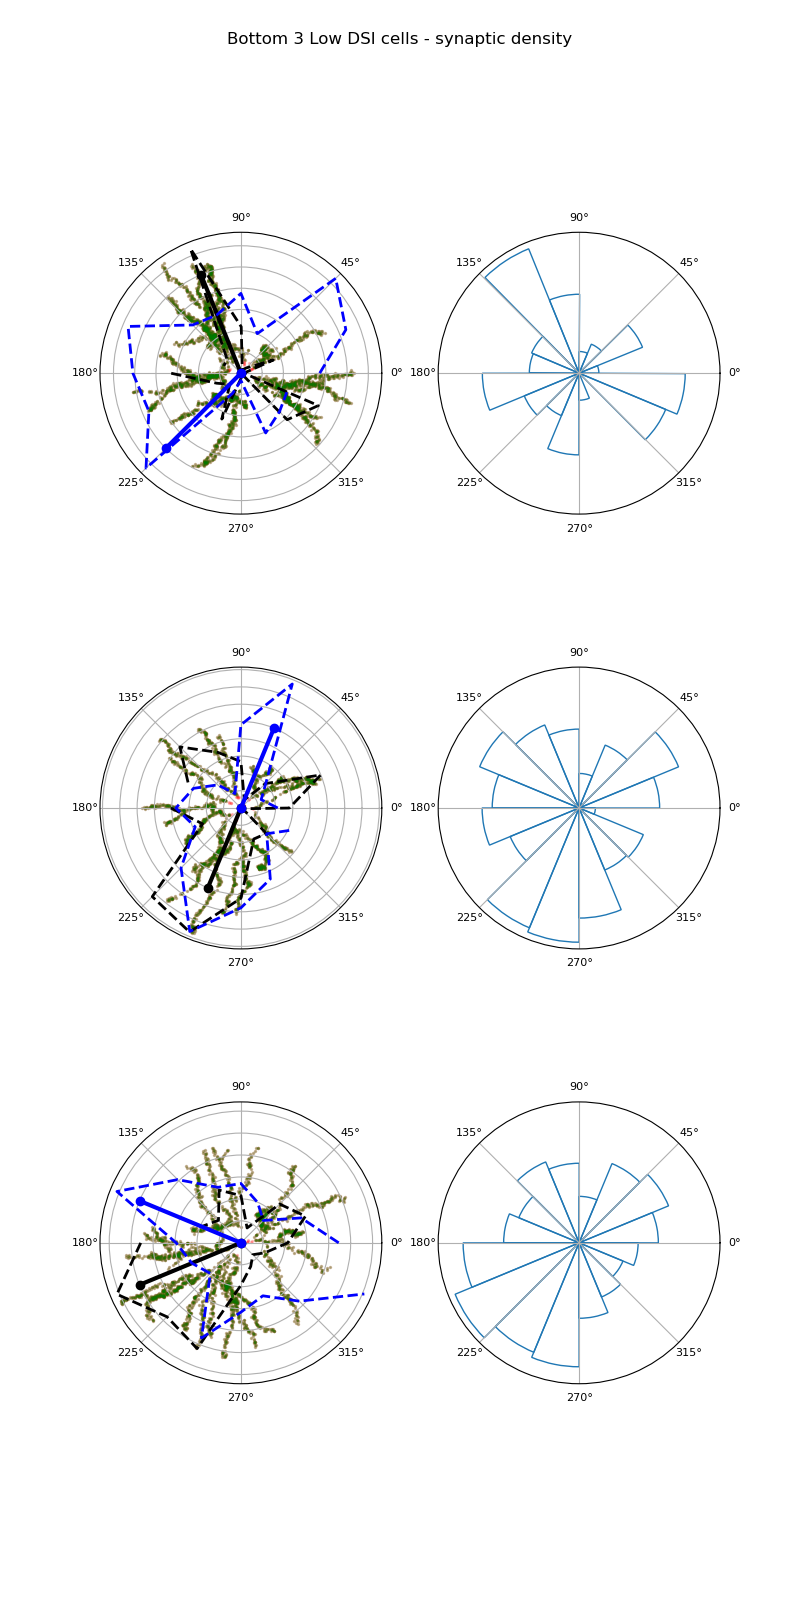

In [47]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
# visualize synaptic density 
Ncells = 3
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Bottom 3 Low DSI cells - synaptic density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_lowDSI[i]))
    dsi_theta = lowDSIdf.iloc[i].pref_dir * (np.pi/180)
    activityLvls= lowDSIdf.iloc[i][2:18]
    basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    skeleton_vertices = syn_pos_basal_norm
    #skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    skel_pos_radial_farther = skel_pos_radial[skel_pos_radial[:,0] > 0.1*np.max(skel_pos_radial[:,0])]
    #x = skel_pos_radial_farther[:,1]
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    #theta[i] = (bins[n.argmax()] + bins[n.argmax() + 1])/2 
    theta[i] = bins[n.argmax()]
    print(theta[i])
    #print((bins[n.argmax()] + bins[n.argmax() + 1])/2)
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=2,color='r',alpha=0.2)
    axs[i,0].scatter(skel_pos_radial_farther[:,1], skel_pos_radial_farther[:,0],s=2,color='g',alpha=0.2)
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[i,0].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[i,0].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[i,0].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # overlay activity curve in diff directions
    activityLvls= lowDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[i,0].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    sig1activity = activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls)
    sig2morph = n*np.max(skel_pos_radial[:,0])/np.max(n)
    correlation = signal.correlate(sig1activity-np.mean(sig1activity), sig2morph- np.mean(sig2morph), mode="full")
    lags = signal.correlation_lags(len(sig1activity), len(sig2morph), mode="full")
    lag = lags[np.argmax(abs(correlation))]
    print(np.max(abs(correlation)), lag)
    axs[i,0].plot([0,dsi_theta],[0,1e5],linewidth = 3, color='b') 
    axs[i,0].plot([0,dsi_theta],[0,1e5],'bo')
    axs[i,0].set_yticklabels([])
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    



[-0.00398883]
[2.74661561]
[1.03236038]


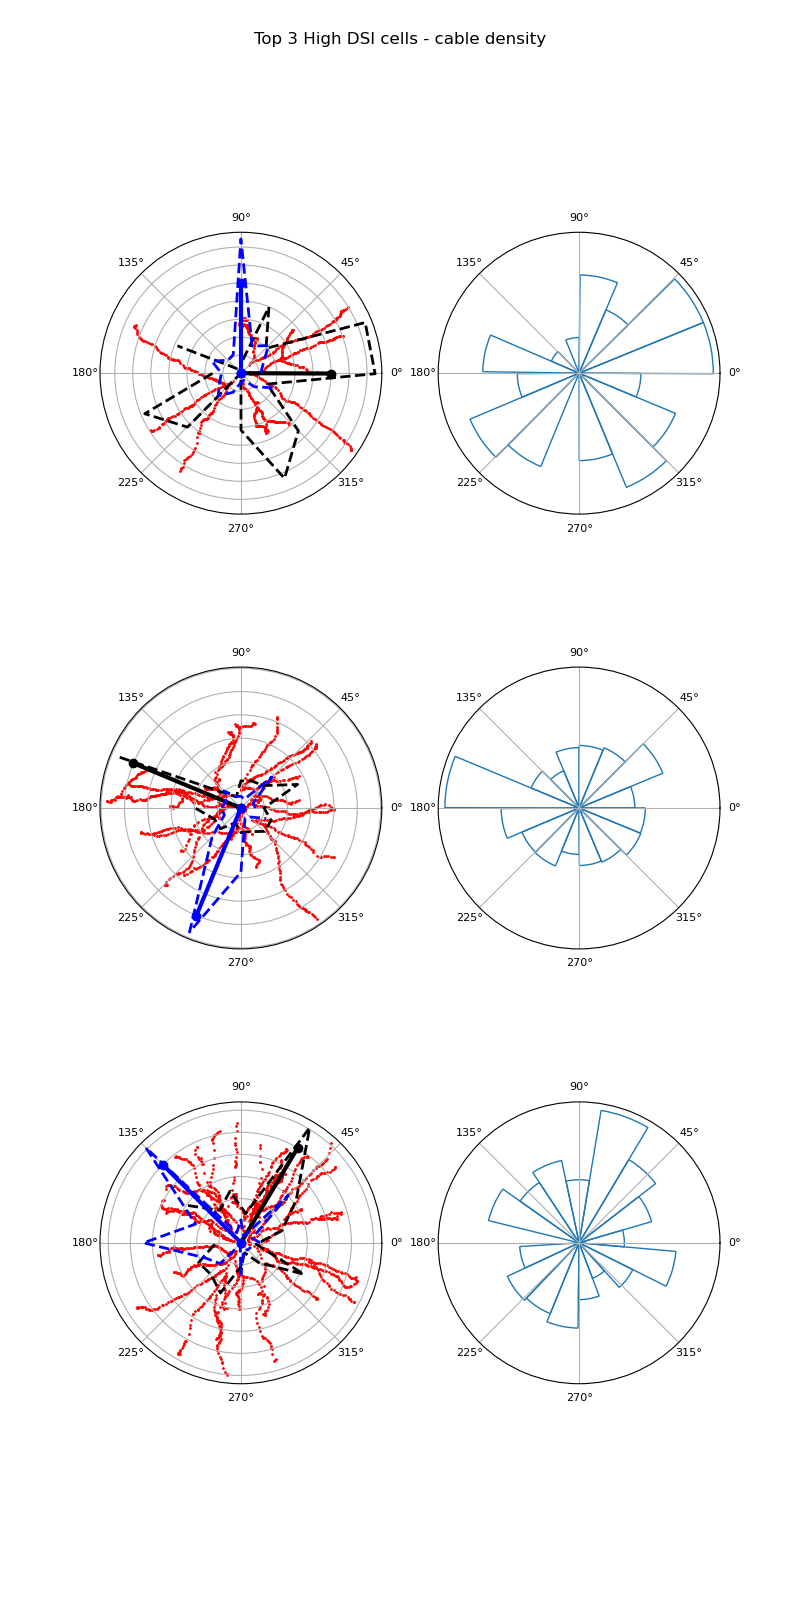

In [24]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
Ncells = 3
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Top 3 High DSI cells - cable density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_highDSI[i]))
    dsi_theta_highDSI = highDSIdf.iloc[i].pref_dir * (np.pi/180)
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    theta[i] = bins[n.argmax()]
    print(theta[i])
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=1,color='r')
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[i,0].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[i,0].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[i,0].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    axs[i,0].plot([0,dsi_theta_highDSI],[0,1e5],linewidth = 3, color='b') 
    axs[i,0].plot([0,dsi_theta_highDSI],[0,1e5],'bo')
    
    activityLvls= highDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[i,0].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    axs[i,0].set_yticklabels([])
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    

In [79]:
theta[i][0]

1.2192192614459274

[1.96220964]
[-2.35600281]
[-2.74710079]


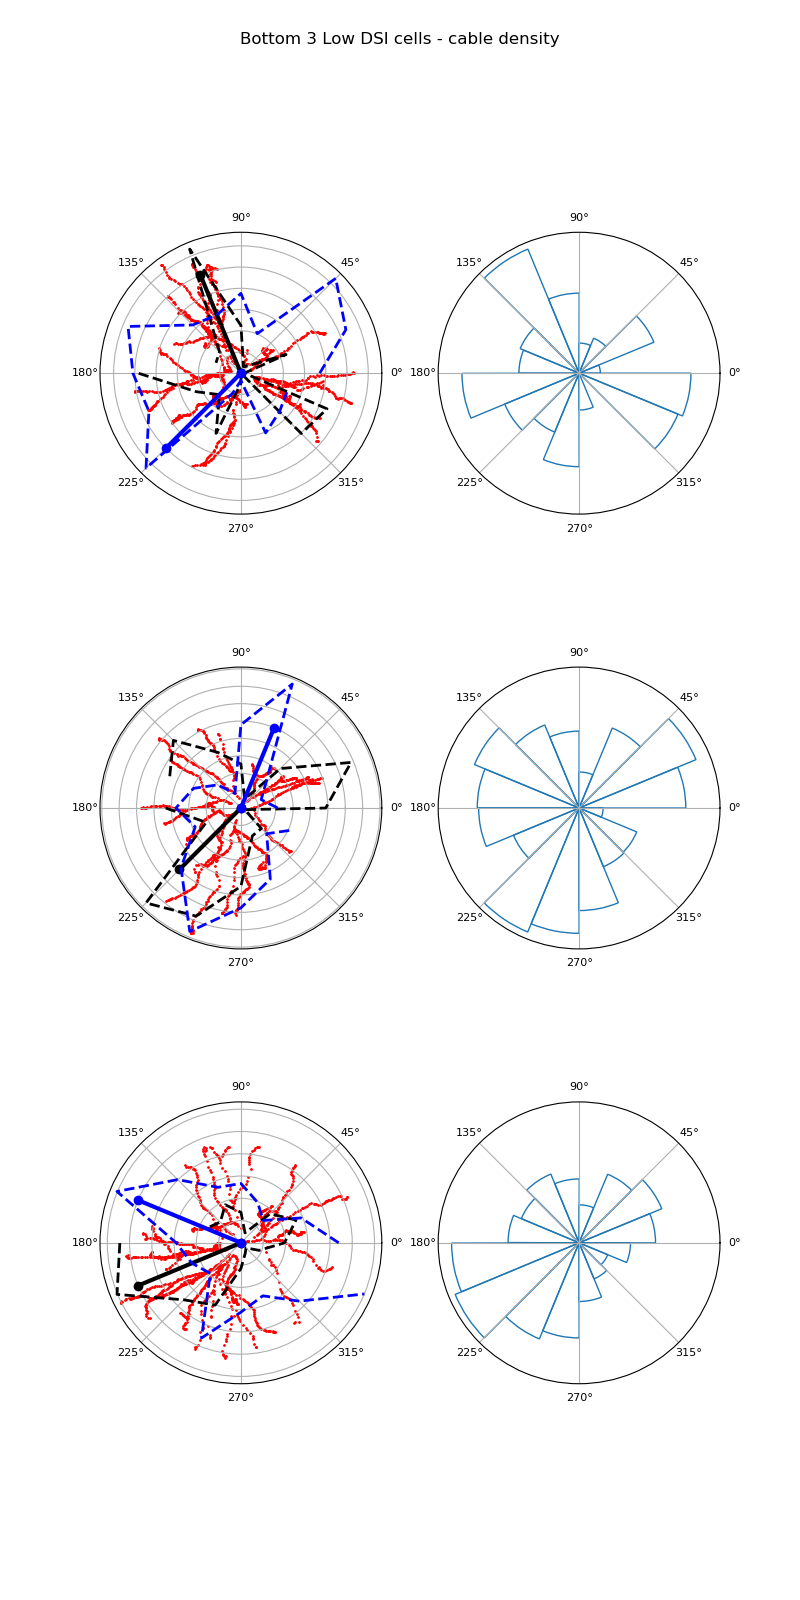

In [26]:
# visualize subplots of first 20 dsi cells with arrow pointing to morph dir
Ncells = 3
fig, axs = plt.subplots(nrows=Ncells, ncols=2, subplot_kw={'projection': 'polar'},figsize=(8,16))
# create bin-wise mask for vertices
nb = 17
bins = np.linspace(-np.pi, np.pi, num=nb)
path_len = np.zeros((nb,1))
fig.suptitle('Bottom 3 Low DSI cells - cable density')

theta = np.zeros((Ncells,1))
for i in range(Ncells):
    nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_files_lowDSI[i]))
    dsi_theta_lowDSI = lowDSIdf.iloc[i].pref_dir * (np.pi/180)
    #basal_dendrite_mask = nrn.anno.basal_mesh_labels.skel_index.to_mesh_mask
    #syndf_basal = nrn.anno.post_syn.filter_query(basal_dendrite_mask).df
    #syn_pos_basal = np.vstack(syndf_basal['ctr_pt_position'].values)
    #syn_pos_basal_norm = np.column_stack((syn_pos_basal[:,0]*4, syn_pos_basal[:,1]*4, syn_pos_basal[:,2]*40))
    #skeleton_vertices = syn_pos_basal_norm
    skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
    nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
    skel_pos_radial, majorAxis,_, _ = getRadialCoord(skeleton_vertices, nrn_somapos)
    x = skel_pos_radial[:,1]
    x = (x+np.pi) % (2*np.pi) - np.pi
    # bin membership for arrays
    bin_inds = np.digitize(x, bins, right=False)
    #for b in range(len(bins)):
    #    path_len[b] = nrn.skeleton.path_length(np.where(bin_inds == b+1))
    n, bins, patches = circular_hist(axs[i,1], x, bins=16,weights=np.ones_like(x), density=True, offset=0, gaps=True)
    theta[i] = bins[n.argmax()]
    print(theta[i])
    axs[i,0].scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=1,color='r')
    # direction of predicted theta from morphology
    #axs[i,0].arrow(0,0,theta[i],1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'red', linewidth = 2)
    axs[i,0].plot([0,theta[i][0]],[0,1e5],linewidth = 3, color='k')  
    axs[i,0].plot([0,theta[i][0]],[0,1e5],'ko') 
    #axs[i,0].bar(bins[:-1], n, align='edge', width=np.diff(bins), fill=True,
    #             linewidth=2,zorder=1)
    # overlay morphological distribution as a line plot
    axs[i,0].plot(bins[:-1],n*np.max(skel_pos_radial[:,0])/np.max(n),linewidth=2,color='k',linestyle='--') 
    # vector direction of pref direction from experiments  
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5,alpha = 0.5,edgecolor = 'black',
    #               facecolor = 'blue', linewidth=2)
    #axs[i,0].arrow(0,0,dsi_theta_highDSI,1e5)
    axs[i,0].plot([0,dsi_theta_lowDSI],[0,1e5],linewidth = 3, color='b') 
    axs[i,0].plot([0,dsi_theta_lowDSI],[0,1e5],'bo')
    
    activityLvls= lowDSIdf.iloc[i][2:18]
    binsActivityLevels = np.linspace(0,2*np.pi,17)
    axs[i,0].plot(binsActivityLevels[:-1],activityLvls*np.max(skel_pos_radial[:,0])/np.max(activityLvls),linewidth=2,color='b',linestyle='--') 
    axs[i,0].set_yticklabels([])
    axs[i,0].tick_params(axis='both', which='major', labelsize=8, pad=0)
    axs[i,1].tick_params(axis='both', which='major', labelsize=8, pad=0)
    

In [23]:
nanmask = ~np.isnan(theta_lowDSI)

In [24]:
from astropy.stats import circcorrcoef
theta_dsi_lowdsi = (dsi_theta_lowDSI+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(theta_dsi_lowdsi[nanmask]), np.squeeze(theta_lowDSI[nanmask]))

-0.283314359181609

In [25]:
dsi_theta_highDSI.shape

(20, 1)

In [26]:
nanmask = ~np.isnan(theta_highDSI)

In [27]:
from astropy.stats import circcorrcoef
theta_dsi_highdsi = (dsi_theta_highDSI+np.pi) % (2*np.pi) - np.pi
circcorrcoef(np.squeeze(theta_dsi_highdsi[nanmask]), np.squeeze(theta_highDSI[nanmask]))

-0.2769116433339885

In [94]:
# do some phasor math with both thetas?
# compare phasor sum values 
# r^2 for unit vectors = 2 + 2cos(theta1-theta2) - so compare cos(theta1-theta2) 
meanPhasor_lowDSI = np.sum(np.cos(theta_dsi_lowdsi[~np.isnan(theta_lowDSI)] - theta_lowDSI[~np.isnan(theta_lowDSI)]))
meanPhasor_highDSI = np.sum(np.cos(theta_dsi_highdsi[~np.isnan(theta_highDSI)] - theta_highDSI[~np.isnan(theta_highDSI)]))

In [95]:
meanPhasor_lowDSI

2.333981986621041

In [96]:
meanPhasor_highDSI

2.7558854239280337

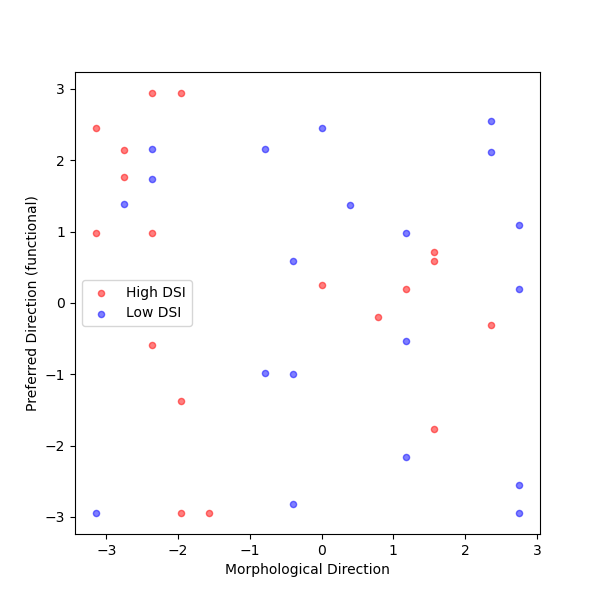

In [97]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(theta_dsi_highdsi, theta_highDSI, s=20,color='r',alpha=0.5)
ax.scatter(theta_dsi_lowdsi, theta_lowDSI, s=20,color='b',alpha=0.5)
ax.set_ylabel('Preferred Direction (functional)')
ax.set_xlabel('Morphological Direction')
ax.legend(['High DSI', 'Low DSI'])


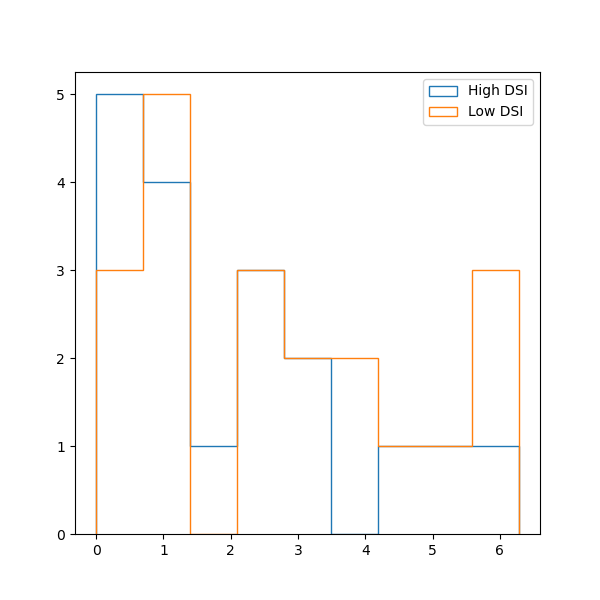

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
highDSIhist = (((dsi_theta_highDSI+np.pi) % (2*np.pi) - np.pi) - theta_highDSI) % (2*np.pi)
lowDSIhist = (((dsi_theta_lowDSI+np.pi) % (2*np.pi) - np.pi) - theta_lowDSI) % (2*np.pi)
ax.hist(highDSIhist,bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.hist(lowDSIhist, bins = np.linspace(0,2*np.pi,10), histtype='step')
ax.legend(['High DSI', 'Low DSI'])

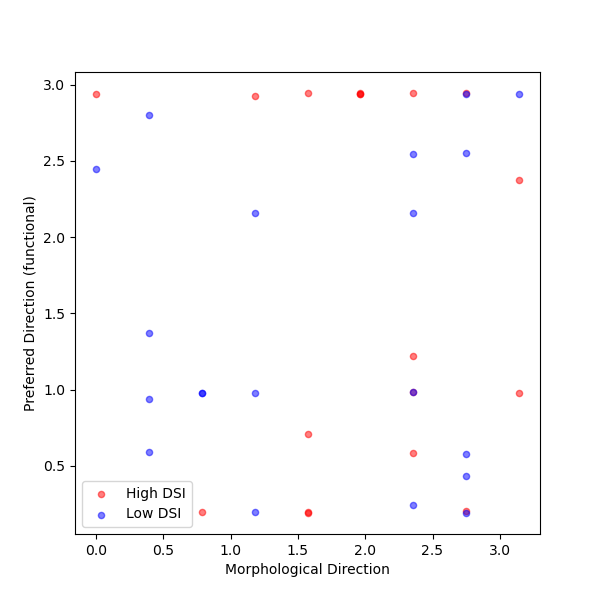

In [36]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(np.abs(theta_dsi_highdsi), np.abs(theta_highDSI), s=20,color='r',alpha=0.5)
ax.scatter(np.abs(theta_dsi_lowdsi), np.abs(theta_lowDSI), s=20,color='b',alpha=0.5)
ax.set_ylabel('Preferred Direction (functional)')
ax.set_xlabel('Morphological Direction')
ax.legend(['High DSI', 'Low DSI'])

In [56]:
from astropy.stats import circcorrcoef
circcorrcoef(np.squeeze(theta[nanmask]), np.squeeze(dsi_theta[nanmask])) 

-0.1289152442276073

In [44]:
angularHet_highDSI.mean()

1.1729209660566757

Text(0.5, 0, 'calc dir')

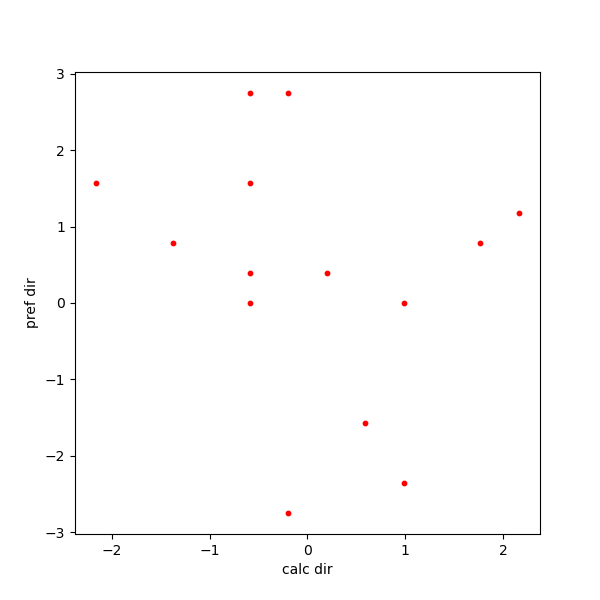

In [209]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)

# wrap dsi_theta to -pi to pi
theta_dsi = (dsi_theta+np.pi) % (2*np.pi) - np.pi
ax.scatter(theta,theta_dsi,s=10,c='r')
ax.set_ylabel('pref dir')
ax.set_xlabel('calc dir')

In [ ]:
# look at individual cells 

In [25]:
neuron_id = DSIdf.iloc[1].pt_root_id

In [26]:
# query soma df to get id for mesh file
neuron_soma_df = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')

In [27]:
# import neuron as skeleton - check how many morphological properties can be applied
from meshparty import meshwork
from angularUtils import *
# the files are named according to the segid and the nucleus_id of each cell
# this is to keep things straight for us as there are often many versions of 
# the same nucleus during proofreading. 
# so lets look up the nuc_id of our neuron

nuc_id=neuron_soma_df.query(f'pt_root_id=={neuron_id}').target_id.values[0]
nuc_type = neuron_soma_df.query(f'pt_root_id=={neuron_id}').cell_type.values[0]
mesh_filename = f"{neuron_id}_{nuc_id}.h5"
nrn = meshwork.load_meshwork(os.path.join(data_root,mesh_filename))

In [28]:
mesh_filename

'864691135478263494_224677.h5'

In [29]:
nuc_type

'23P'

In [4]:
# get sub-skeletons - apical/basal/all dendrites
apical_dendrite_mesh = nrn.anno.apical_mesh_labels.mesh_index
apical_dendrite_skel = nrn.anno.apical_mesh_labels.skel_index

basal_dendrite_mesh = nrn.anno.basal_mesh_labels.mesh_index
basal_dendrite_skel = nrn.anno.basal_mesh_labels.skel_index

dendrite_skel = nrn.skeleton.SkeletonIndex(np.concatenate((np.array(basal_dendrite_skel), np.array(apical_dendrite_skel))))
dendrite_mesh = dendrite_skel.to_mesh_index

dendrite_mesh_mask = (nrn.anno.basal_mesh_labels.mesh_mask) | (nrn.anno.apical_mesh_labels.mesh_mask)
dendrite_skel_mask = (nrn.anno.basal_mesh_labels.skel_mask) | (nrn.anno.apical_mesh_labels.skel_mask)

NameError: name 'nrn' is not defined

In [35]:
# get coordinates of skeleton wrt the soma 
# import functions 
from angularUtils import *
skeleton_vertices = nrn.skeleton.vertices[(nrn.anno.basal_mesh_labels.skel_mask)]
nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
skeleton_pos_wrtsoma = skeleton_vertices - nrn_somapos
skel_pos_radial, majorAxis, skel_pos_transformed, skel_pos_radial_transformed = getRadialCoord(skeleton_vertices, nrn_somapos)

In [41]:
bins_theta = np.linspace(0,2*np.pi,12)
hist, bin_edges = np.histogram(skel_pos_radial[:,1], bins=bins_theta)
theta = (bin_edges[hist.argmax()] + bin_edges[hist.argmax() + 1])/2

In [42]:
theta

0.28559933214452665

In [36]:
majorAxis

array([-0.91369146,  0.40640855])

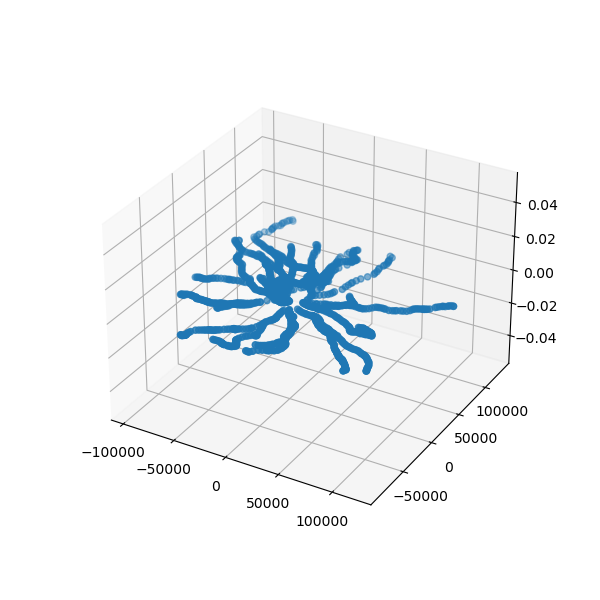

In [37]:
# plot 3D representation of dendrite
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')   
ax.scatter3D(skeleton_pos_wrtsoma[:,0],skeleton_pos_wrtsoma[:,1],skeleton_pos_wrtsoma[:,2])


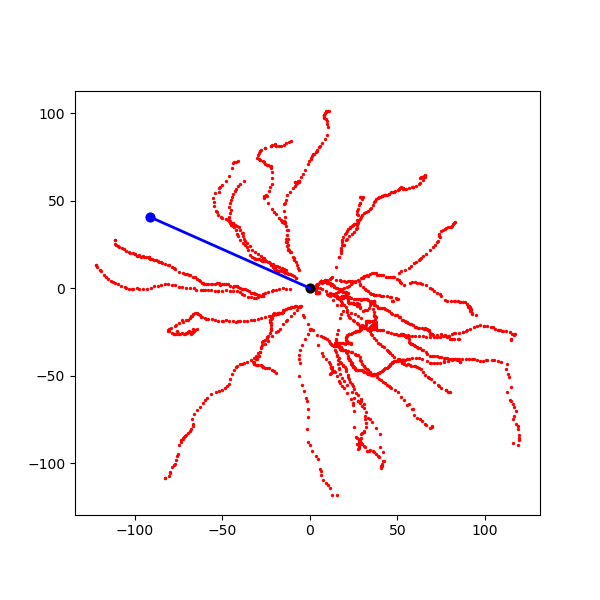

In [49]:
# plot pca vectors along with the data points
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()   

ax.scatter(skeleton_pos_wrtsoma[:,0]/1000,skeleton_pos_wrtsoma[:,2]/1000,s=2,color='r')
#ax.scatter(skel_pos_transformed[:,0]/1000,skel_pos_transformed[:,1]/1000,s=2,color='r')
ax.plot([0,majorAxis[0]*100],[0,majorAxis[1]*100],linewidth=2,color='b') 
ax.scatter(majorAxis[0]*100,majorAxis[1]*100,s=40,color='b') 
ax.scatter(0,0,s=40,color='k')
ax.set_aspect('equal')

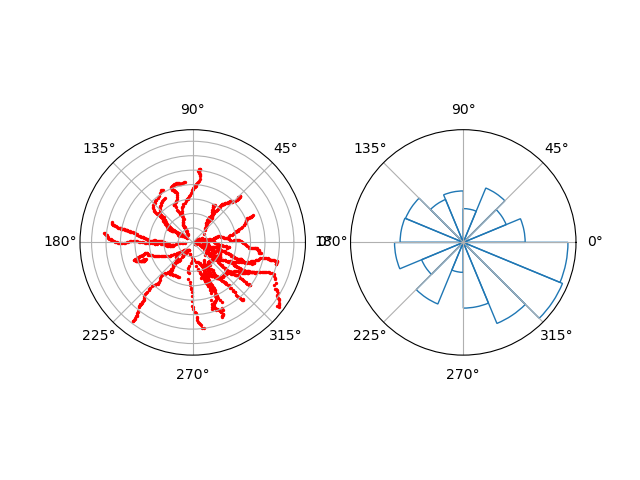

In [119]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': 'polar'})
x = skel_pos_radial[:,1]
#n, bins, patches = circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True)

radius = n
widths = np.diff(bins)
#ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths,
#                    edgecolor='C0', fill=False, linewidth=1)
ax1.scatter(skel_pos_radial[:,1], skel_pos_radial[:,0],s=2,color='r')
ax1.set_yticklabels([])

n, bins, patches = circular_hist(ax2, x, bins=16, density=True, offset=0, gaps=True)


In [120]:
bins_theta = np.linspace(0,2*np.pi,12)
hist, bin_edges = np.histogram(skel_pos_radial[:,1], bins=bins_theta)

In [122]:
theta = (bin_edges[hist.argmax()] + bin_edges[hist.argmax() + 1])/2

In [127]:
x = (x+np.pi) % (2*np.pi) - np.pi
bins = np.linspace(-np.pi, np.pi, num=17)
n, bins = np.histogram(x, bins=bins)

In [128]:
theta = (bins[n.argmax()] + bins[n.argmax() + 1])/2

In [129]:
theta

-0.5890486225480862

In [110]:
bin_vals = (bins[:-1] + bins[1:])/2

In [113]:
bin_vals

array([-2.94370401, -2.55116089, -2.15861776, -1.76607463, -1.37353151,
       -0.98098838, -0.58844525, -0.19590212,  0.196641  ,  0.58918413,
        0.98172726,  1.37427039,  1.76681351,  2.15935664,  2.55189977,
        2.9444429 ])

In [117]:
np.degrees(bin_vals[np.argmax(n)]) + 360

326.2845706596386

In [134]:
# avoid segment map - workflow:
# test
upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []

# filter branch points by those in dendrite
dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(basal_dendrite_skel))))
branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
for par in branch_parents.to_mesh_region:
    seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    upstream_info.append(seg)
    upstream_radii.append(seg.r_eff.unique())
    #upstream_radii.append(seg.area.unique())
    upstream_area_factor.append(seg.area_factor.unique())
for child in branch_children:
    seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    downstream_info.append(seg)
    downstream_radii.append(seg.r_eff.unique())
    #downstream_radii.append(seg.area.unique())
    downstream_area_factor.append(seg.area_factor.unique())

In [138]:
upstream_filt = []
upstream_inds = []
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

In [139]:
# create sq sum array of downstream radii

def getSumDS(upstream_filt,downstream_radii,a):
    sumds = np.zeros((len(upstream_filt),1))
    inds = 0
    for i in range(len(upstream_radii)):
        if (i in upstream_inds):
            sumds[inds] = np.sum((np.array(downstream_radii[inds])/1000)**a)
            inds = inds+1
    return sumds

In [140]:
len(upstream_filt)

34

In [141]:
# fitting alpha - visualize wrt strahler number - does your goodness of fit for an alpha vary in space? 
# Can also plot as a function of strahler number


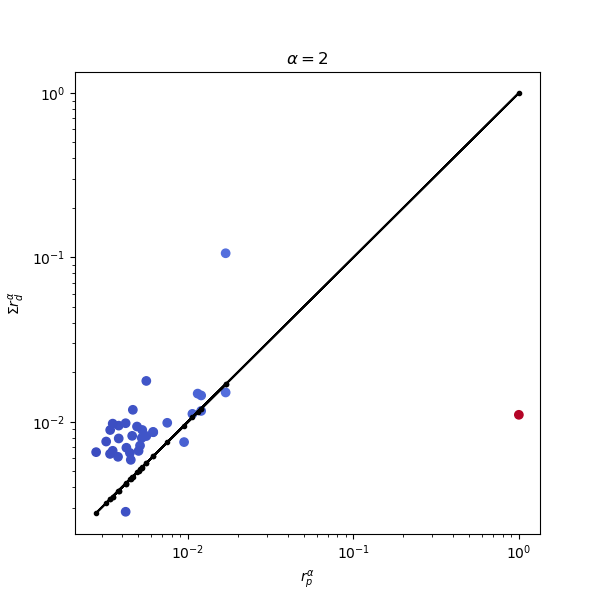

In [142]:
# scatter upstream and downstream radii ^2 etc
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
a = 2
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=np.array(upstream_filt)/1000,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
#plt.coolwarm()
#ax.scatter(np.array(upstream_radii)/1000, sumds)

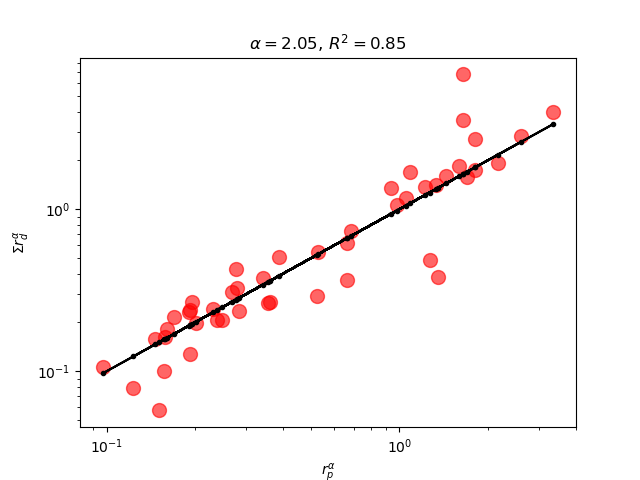

In [123]:
# get best fit alpha for full or part of the dendritic tree

import operator

alist = np.linspace(1,3.5,20)
r2val = np.zeros_like(alist)

for aind,a in enumerate(alist):
    sumds = getSumDS(upstream_filt,downstream_radii,a)
    #print(a)
    # Calculate r2 score 
    x_in = np.log(np.squeeze((np.array(upstream_filt)/1000)**a))
    y_in = np.log(np.squeeze(sumds))
    
    #x_in = np.squeeze((np.array(upstream_filt)/1000)**a)
    #y_in = np.squeeze(sumds)
    
    L1 = sorted(zip(x_in,y_in), key=operator.itemgetter(0))
    x, y = zip(*L1)
    x = np.asarray(x)
    y = np.asarray(y)
    SStot = np.sum((y - np.mean(y))**2)
    SSres = np.sum((y- x)**2)

    r2val[aind] = 1-(SSres/SStot)

r2val_set = np.max(r2val)
aset = alist[np.argmax(r2val)]

# plot the selected alpha value
sumds_plot = getSumDS(upstream_filt,downstream_radii,aset)
f,ax = plt.subplots()
ax.scatter((np.array(upstream_filt)/1000)**aset,sumds_plot,s=100,c='red',label='Data',alpha=0.6)
ax.plot((np.array(upstream_filt)/1000)**aset, (np.array(upstream_filt)/1000)**aset, 'k.-')

ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(np.round(aset,2)) + r', $R^2 =$' + str(np.round(r2val_set,2)))
ax.set_yscale('log')
ax.set_xscale('log')

In [124]:
# Do apical and basal dendrites have differential morphologies because of a spread in inputs? 


In [149]:
# Differential scaling laws in angular regions? 
# extract parts of skeleton that are in the angular region vs not
# check whether area factors are differentially distributed for basal and apical dendrites separately

# transform coordinates
# get coordinates of skeleton wrt the soma 
# import functions 
from angularUtils import *
apical_vertices = nrn.skeleton.vertices[nrn.anno.apical_mesh_labels.skel_mask]
basal_vertices = nrn.skeleton.vertices[nrn.anno.basal_mesh_labels.skel_mask]
nrn_somapos = nrn.skeleton.vertices[nrn.skeleton.root]
apical_pos_wrtsoma = apical_vertices - nrn_somapos
basal_pos_wrtsoma = basal_vertices - nrn_somapos
apical_pos_radial, majorAxis, apical_pos_transformed, apical_pos_radial_transformed = getRadialCoord(apical_vertices, nrn_somapos)
basal_pos_radial, majorAxis, basal_pos_transformed, basal_pos_radial_transformed = getRadialCoord(basal_vertices, nrn_somapos)

angularRatio_basal, withinAngle, basal_in_range_mask = getAngularDensity(nrn,basal_pos_radial_transformed,nrn.anno.segment_properties.df,'len',angle=np.pi/2)
angularRatio_apical, withinAngle, apical_in_range_mask = getAngularDensity(nrn,apical_pos_radial_transformed,nrn.anno.segment_properties.df,'len',angle=np.pi/2)

In [150]:
angularRatio_apical

0.5147194635650768

In [151]:
basalInRangeMask = nrn.skeleton.SkeletonIndex(np.where(basal_in_range_mask)).to_mesh_mask
basalMask = nrn.anno.basal_mesh_labels.mesh_mask

apicalInRangeMask = nrn.skeleton.SkeletonIndex(np.where(apical_in_range_mask)).to_mesh_mask
apicalMask = nrn.anno.apical_mesh_labels.mesh_mask


In [152]:
np.squeeze(np.array(np.where(apical_in_range_mask))).shape

(1285,)

In [153]:
np.array(apical_dendrite_skel).shape

(2434,)

In [212]:
# avoid segment map - workflow:
# test
upstream_radii = []
upstream_info = []
downstream_info = []
downstream_radii = []
upstream_area_factor = []
downstream_area_factor = []
bp_angle = []

# filter branch points by those in dendrite
dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.array(basal_dendrite_skel))))
#dendrite_branch_points = nrn.skeleton.SkeletonIndex(list(set(np.array(nrn.skeleton.branch_points)).intersection(np.squeeze(np.array(np.where(basal_in_range_mask))))))
branch_children=nrn.skeleton.child_nodes(dendrite_branch_points)
branch_parents=nrn.skeleton.parent_nodes(dendrite_branch_points)
for par in branch_parents.to_mesh_region:
    seg=nrn.anno.segment_properties.filter_query(par.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    upstream_info.append(seg)
    upstream_radii.append(seg.r_eff.unique())
    #upstream_radii.append(seg.area.unique())
    upstream_area_factor.append(seg.area_factor.unique())
for child in branch_children:
    seg=nrn.anno.segment_properties.filter_query(child.to_mesh_mask).df
    #seg.drop_duplicates(subset = ["area"])
    downstream_info.append(seg)
    downstream_radii.append(seg.r_eff.unique())
    #downstream_radii.append(seg.area.unique())
    downstream_area_factor.append(seg.area_factor.unique())
    
ptpos = nrn.skeleton.vertices[dendrite_branch_points]
_,_,_, pos_radial_transformed = getRadialCoord(ptpos, nrn_somapos)
angular_dev_fromxaxis = np.abs(np.pi/2 - np.abs(pos_radial_transformed[:,1]))


In [213]:
upstream_filt = []
upstream_inds = []
upstream_filt = [x for i,x in enumerate(upstream_radii) if x]
upstream_inds = [i for i,x in enumerate(upstream_radii) if x]

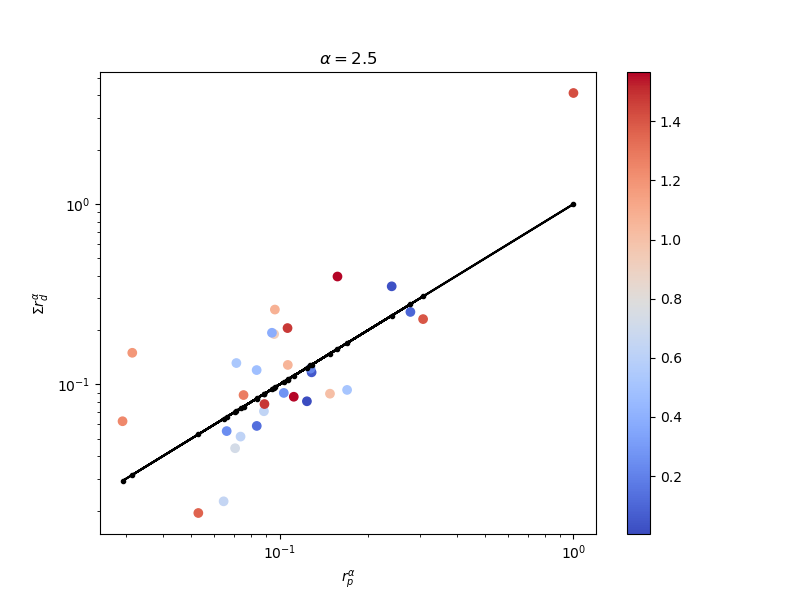

In [215]:
# looking at just basal part - color pts by whether they are inside angular region vs not
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
a = 2.5
sumds = getSumDS(upstream_filt,downstream_radii,a)
maxUS = np.max((np.array(upstream_filt)/1000)**a)
pos_radial_norm = pos_radial_transformed

scatterplot = ax.scatter((np.array(upstream_filt)/1000)**a/maxUS, sumds/maxUS,c=angular_dev_fromxaxis,cmap='coolwarm')
ax.plot((np.array(upstream_filt)/1000)**a/maxUS, (np.array(upstream_filt)/1000)**a/maxUS, 'k.-')
ax.set_ylabel(r'$\Sigma r_d^{\alpha}$')
ax.set_xlabel(r'$r_p^{\alpha}$')
ax.set_title(r'$\alpha =$' + str(a))
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(scatterplot)

#cbar = plt.colorbar()


In [216]:
# Question - how to account for area factor while looking at area scaling? 
# normalize by area factor and plot? 



In [18]:
# Other morphology questions:
# get 0th level axis and get +/- 45 degree slices 
# - Sum over lengths of segments in a given +/- 45deg area along the axis of highest variation 
# - length over branching pts and length/syn density for these areas
